# **Data Wrangling: Casual Conversation Chatbot (Chit-Chat Bot)**

* **Group 8:** Aktham Almomani
* **Course:** Natural Language Processing and GenAI (AAI-520-04) / University Of San Diego
* **Semester:** Winter 2024

<center>
    <img src="https://github.com/akthammomani/AI_powered_heart_disease_risk_assessment_app/assets/67468718/2cab2215-ce7f-4951-a43a-02b88a5b9fa9" alt="wrnagling">
</center>

## **Contents**<a is='Contents'></a>
* [Dataset](#Dataset)
* [Setup and preliminaries](#Setup_and_preliminaries)
  * [Import Libraries](#Import_libraries)
* [Importing Dataset](#Importing_dataset)
* [Data Wrangling & Preprocessing](#Data_Wrangling_Preprocessing)
* [Saving Final Dataset](#Saving_Final_Dataset)
* [Conversations and Turns Count](#Conversations_and_Turns_Count)


## **Dataset**<a id='Dataset'></a>
[Contents](#Contents)

**[The Cornell Movie Dialogues Dataset](https://www.kaggle.com/datasets/rajathmc/cornell-moviedialog-corpus)** is a well-known and widely-used dataset for building conversational models, particularly chatbots. It contains dialogues from over 600 movies, with a rich collection of character interactions, making it an excellent resource for training dialogue-based models.

**Key Features of the Dataset:**
* **Multi-Turn Conversations:** The dataset includes over 220,000 conversational exchanges between pairs of movie characters. These exchanges provide valuable data for modeling multi-turn conversations, which are essential for creating chatbots that can engage in longer, more meaningful conversations.

* **Diverse Dialogue Styles:** The dataset spans many genres and includes conversations from a wide range of characters, settings, and speaking styles, from casual and humorous dialogue to intense or emotional exchanges. This diversity is ideal for training models that can handle different conversational tones and contexts.

* **Structured Data:**

   * `movie_lines.txt:` Contains individual lines of dialogue, along with metadata such as the character and movie from which the line originates.
   * `movie_conversations.txt:` Links together individual lines into conversations, providing a structured flow of multi-turn dialogue.

* **Movie Metadata:** While the primary focus is on dialogue, the dataset also includes metadata such as movie titles, character names, and years of release. These can be useful for building context-aware systems or for generating trivia-based responses, though they are not necessary for general chit-chat functionality.

**Dataset Composition:**
* Number of Conversations: Over `83,000` multi-turn conversations.
* Number of Dialogue Lines: Around `220,000` individual lines of dialogue.
* Character and Movie Diversity: Dialogue from over `10,000` characters in `617` different movies, offering a wide variety of conversational topics and styles.

**Why This Dataset?**
The Cornell Movie Dialogues Dataset is particularly suitable for training generative chatbots because:

* **Rich Multi-Turn Structure:** It offers high-quality dialogue exchanges that are perfect for building models capable of sustaining coherent conversations.
* **Diverse Conversations:** The wide range of conversational tones allows models to learn different ways of responding, making the chatbot more versatile in its responses.
* **Well-Structured Data:** The structured format of conversations and lines makes it easier to process, tokenize, and use for training conversational models.

By using this dataset, we can build a chatbot that is capable of handling casual conversations, answering questions, and maintaining coherent multi-turn dialogue, making it ideal for applications like customer support, virtual assistants, and entertainment bots.

## **Setup and preliminaries**<a id='Setup_and_preliminaries'></a>
[Contents](#Contents)

### **Import libraries**<a id='Import_libraries'></a>
[Contents](#Contents)

In [34]:
#Let's import the necessary packages:
import json
import re
import pandas as pd
from textblob import TextBlob
import spacy
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import random

pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', 4000) # 100 means 100 characters in the col

## **Importing Dataset**<a id='Importing_dataset'></a>
[Contents](#Contents)

In [6]:
# Load movie lines and conversations into DataFrames:
def load_data_to_dataframe():
    # Load movie lines:
    lines_data = []
    with open("movie_lines.txt", encoding='utf-8', errors='ignore') as file:
        for line in file:
            line_parts = line.split(" +++$+++ ")
            if len(line_parts) == 5:
                line_id, character_id, movie_id, character_name, text = line_parts
                lines_data.append([line_id, character_id, movie_id, character_name, text.strip()])

    # Create DataFrame for lines:
    lines_df = pd.DataFrame(lines_data, columns=["line_id", "character_id", "movie_id", "character_name", "text"])

    # Load movie conversations:
    conversations_data = []
    with open("movie_conversations.txt", encoding='utf-8', errors='ignore') as file:
        for line in file:
            line_parts = line.split(" +++$+++ ")
            if len(line_parts) == 4:
                character_ids = line_parts[0:2]
                movie_id = line_parts[2]
                conversation_ids = eval(line_parts[3])  # List of line IDs
                conversations_data.append([character_ids, movie_id, conversation_ids])

    # Create DataFrame for conversations:
    conversations_df = pd.DataFrame(conversations_data, columns=["character_ids", "movie_id", "conversation_ids"])

    # Load movie metadata:
    movie_metadata = []
    with open("movie_titles_metadata.txt", encoding='utf-8', errors='ignore') as file:
        for line in file:
            line_parts = line.split(" +++$+++ ")
            if len(line_parts) >= 5:
                movie_id, movie_title, movie_year, movie_rating, movie_genres = line_parts[:5]
                movie_metadata.append([movie_id.strip(), movie_title.strip(), movie_year.strip(), movie_rating.strip(), movie_genres.strip()])

    # Create DataFrame for movies:
    movies_df = pd.DataFrame(movie_metadata, columns=["movie_id", "title", "year", "rating", "genres"])

    return lines_df, conversations_df, movies_df

# Display complete data with conversation IDs, turn IDs, and progress tracking:
def display_conversations_df(conversations_df, lines_df, movies_df):
    conversation_list = []
    
    # Loop through the conversations and assign conversation IDs:
    for convo_id, convo_row in tqdm(enumerate(conversations_df.itertuples(), start=1), total=len(conversations_df), desc="Processing Conversations"):
        convo_lines = []
        for turn_id, line_id in enumerate(convo_row.conversation_ids, start=1):
            # Get the line text from the lines_df
            line_data = lines_df[lines_df['line_id'] == line_id]
            if not line_data.empty:
                text = line_data.iloc[0]['text']
                character_name = line_data.iloc[0]['character_name']
                movie_id = line_data.iloc[0]['movie_id']

                # Get movie title and year from movies_df
                movie_data = movies_df[movies_df['movie_id'] == movie_id]
                if not movie_data.empty:
                    movie_title = movie_data.iloc[0]['title']
                    movie_year = movie_data.iloc[0]['year']
                else:
                    movie_title = "Unknown"
                    movie_year = "Unknown"
                
                # Append conversation with conversation ID, turn ID, and text:
                convo_lines.append([convo_id, turn_id, movie_title, movie_year, character_name, text])
        
        # Add all turns of the conversation to the list:
        conversation_list.extend(convo_lines)

    # Create DataFrame for complete conversations with conversation and turn IDs:
    full_conversations_df = pd.DataFrame(conversation_list, columns=["Conversation ID", "Turn ID", "Movie Title", "Year", "Character", "Text"])
    return full_conversations_df

In [7]:
# Load data into DataFrames:
lines_df, conversations_df, movies_df = load_data_to_dataframe()

# Display data in a structured DataFrame:
full_conversations_df = display_conversations_df(conversations_df, lines_df, movies_df)

# Show the first 5 conversations in the DataFram:
full_conversations_df.head()

Processing Conversations: 100%|████████████████████████████████████████████████| 83097/83097 [3:45:22<00:00,  6.15it/s]


,Conversation ID,Turn ID,Movie Title,Year,Character,Text
0,1,1,10 things i hate about you,1999,BIANCA,Can we make this quick? Roxanne Korrine and A...
1,1,2,10 things i hate about you,1999,CAMERON,"Well, I thought we'd start with pronunciation,..."
2,1,3,10 things i hate about you,1999,BIANCA,Not the hacking and gagging and spitting part....
3,1,4,10 things i hate about you,1999,CAMERON,Okay... then how 'bout we try out some French ...
4,2,1,10 things i hate about you,1999,BIANCA,You're asking me out. That's so cute. What's ...


In [8]:
full_conversations_df.shape

(304713, 6)

In [12]:
# Save DataFrame as CSV:
full_conversations_df.to_csv('full_conversations.csv', encoding='utf-8')

## **Data Wrangling & Preprocessing**<a id='Data_Wrangling_Preprocessing'></a>
[Contents](#Contents)

In this notebook, we perform the critical steps of data wrangling and preprocessing to prepare the **Cornell Movie Dialogues Dataset** for training a conversational chatbot. This dataset was imported from **Kaggle**, and it contains dialogues from a variety of movies, offering a rich set of conversation pairs for building a chatbot capable of engaging in casual conversations.

**Data Import:**

The dataset was sourced from **Kaggle** and consists of multiple text files including:

* `movie_lines.txt:` Contains individual lines of dialogue along with metadata.
* `movie_conversations.txt:` Provides conversation groupings, linking individual lines to create multi-turn dialogues.

We imported these files into Python and structured the data for efficient processing. The data was then loaded into a Pandas DataFrame for easier manipulation.

**Data Cleaning and Column Selection:**

Since the focus of our chatbot is **casual conversation** rather than movie-specific trivia or character emulation, we discarded irrelevant columns such as:

* **Movie Titles:** Not essential for casual conversations.
* **Character Names:** Not required for general chit-chat.
* **Years:** Historical context is unnecessary in a conversational chatbot.

After removing these unnecessary columns, we focused on the core **dialogue text**, which will serve as the foundation for training the chatbot.

**Preprocessing Pipeline:**

The preprocessing pipeline is designed to clean and standardize the conversational data for input into the model. The steps include:

* **Expanding Contractions:** Common English contractions (e.g., can't to cannot) were expanded to ensure the text is uniform.
* **Removing Non-Dialogue Elements:** Stage directions and non-verbal actions, such as descriptions in parentheses or square brackets, were removed to keep only the spoken parts.
* **Preserving Proper Nouns:** Using natural language processing (NLP), we ensured that proper nouns such as movie titles, places, and names were preserved in their original form, while the rest of the text was lowercased.
* **Normalizing Numbers:** Numbers and years were normalized by replacing them with tokens such as <NUMBER> and <YEAR>.
* **Truncating Long Utterances:** Very long dialogue lines were truncated to a maximum word length to maintain coherence.
* **Final Cleanup:** The text was cleaned of any remaining unwanted characters and extra spaces.
* 
Each step in this pipeline helps standardize the input text and removes noise that could negatively impact the chatbot's performance. After applying the cleaning pipeline, the data was stored in a **cleaned DataFrame** for subsequent processing and model training.

By applying this preprocessing pipeline, we ensure the text is well-structured, uniform, and ready for the next steps in building our chatbot.

In [21]:
conversational_data = pd.read_csv("full_conversations.csv")

In [22]:
# Drop unnecessary columns for casual conversation:
conversational_data = full_conversations_df.drop(columns=["Movie Title", "Year", "Character"])


# Save DataFrame as CSV:
conversational_data.to_csv('full_conversations_v2.csv', encoding='utf-8')

In [23]:
conversational_data.head()

,Conversation ID,Turn ID,Text
0,1,1,Can we make this quick? Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad. Again.
1,1,2,"Well, I thought we'd start with pronunciation, if that's okay with you."
2,1,3,Not the hacking and gagging and spitting part. Please.
3,1,4,Okay... then how 'bout we try out some French cuisine. Saturday? Night?
4,2,1,You're asking me out. That's so cute. What's your name again?


In [24]:
# Load the English language model for Spacy:
nlp = spacy.load("en_core_web_sm")

In [25]:
# Define all the preprocessing functions:
def expand_contractions(text):
    """Expand common English contractions."""
    contractions = {
        "won't": "will not", "can't": "cannot", "n't": " not", "it's": "it is",
        "i'm": "i am", "she's": "she is", "he's": "he is", "they're": "they are",
        "we're": "we are", "you're": "you are", "isn't": "is not", "aren't": "are not",
        "let's": "let us", "wouldn't": "would not", "couldn't": "could not"
    }
    for contraction, expanded in contractions.items():
        text = re.sub(r"\b" + contraction + r"\b", expanded, text)
    return text

def remove_non_dialogue_lines(text):
    """Remove stage directions or non-verbal actions in parentheses and square brackets."""
    text = re.sub(r"\([^)]*\)", "", text)  # Remove anything inside parentheses
    text = re.sub(r"\[.*?\]", "", text)    # Remove anything inside square brackets
    return text.strip()

def preserve_proper_nouns(text):
    """Preserve proper nouns like movie titles, places, and names."""
    doc = nlp(text)
    new_text = []
    for token in doc:
        if token.ent_type_ in ['PERSON', 'ORG', 'GPE', 'WORK_OF_ART']:  # Keep proper nouns intact
            new_text.append(token.text)
        else:
            new_text.append(token.text.lower())  # Lowercase other words
    return " ".join(new_text)

def correct_spelling(text):
    """Correct spelling errors using TextBlob."""
    return str(TextBlob(text).correct())

def normalize_numbers(text):
    """Normalize numbers and years in text."""
    text = re.sub(r'\b\d{4}\b', ' <YEAR> ', text)  # Replace 4-digit numbers (years) with <YEAR>
    text = re.sub(r'\b\d+\b', ' <NUMBER> ', text)  # Replace other numbers with <NUMBER>
    return text

def truncate_long_utterances(text, max_length=50):
    """Truncate overly long utterances."""
    words = text.split()
    if len(words) > max_length:
        return " ".join(words[:max_length]) + "..."  # Truncate to max_length and add ellipsis
    return text

# Combine all the steps into one cleaning function:
def clean_text(text):
    """Main cleaning function applying all the recommended steps."""
    text = expand_contractions(text)
    text = remove_non_dialogue_lines(text)
    # text = correct_spelling(text)  # Optional
    text = preserve_proper_nouns(text)
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)  # Remove unwanted characters
    text = normalize_numbers(text)
    text = truncate_long_utterances(text)
    text = re.sub(r"\s+", " ", text).strip()  # Final clean-up
    return text




In [26]:
# Apply the `clean_text` function to the 'Text' column with progress tracking:
tqdm.pandas(desc="Cleaning Text Data")  # Add a progress bar description:
conversational_data['cleaned_text'] = conversational_data['Text'].progress_apply(clean_text)



Cleaning Text Data: 100%|█████████████████████████████████████████████████████| 304713/304713 [48:35<00:00, 104.50it/s]


In [27]:
conversational_data.head()

,Conversation ID,Turn ID,Text,cleaned_text
0,1,1,Can we make this quick? Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad. Again.,can we make this quick Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break up on the quad again
1,1,2,"Well, I thought we'd start with pronunciation, if that's okay with you.",well i thought we d start with pronunciation if that s okay with you
2,1,3,Not the hacking and gagging and spitting part. Please.,not the hacking and gagging and spitting part please
3,1,4,Okay... then how 'bout we try out some French cuisine. Saturday? Night?,okay then how bout we try out some french cuisine saturday night
4,2,1,You're asking me out. That's so cute. What's your name again?,you re asking me out that s so cute what s your name again


## **Saving Final Dataset**<a id='Saving_Final_Dataset'></a>
[Contents](#Contents)

In [28]:
# Save the cleaned data to a CSV or another format:
conversational_data.to_csv('cleaned_conversational_data_v1.csv', index=False)

## **Conversations and Turns Count**<a id='Conversations_and_Turns_Count'></a>
[Contents](#Contents)

In here, we'll analyze the length of conversations within the dataset, specifically focusing on the number of turns per conversation. This analysis is essential for understanding the structure of the conversations and determining the distribution of conversation lengths, which is a critical step in preparing the dataset for training a chatbot model like GPT-2.

By grouping the data based on the Conversation ID and counting the number of Turn IDs per conversation, below function calculates various statistics such as:

* Total number of unique conversations in the dataset.
* The minimum, maximum, average, and median number of turns per conversation.
* The 25th and 75th percentiles of conversation lengths, which provide insight into how most conversations are distributed in terms of their length.

In [32]:
# Analyze conversation lengths based on unique Conversation IDs:
def analyze_conversation_lengths(conversational_data, conversation_id_column='Conversation ID', turn_column='Turn ID'):
    # Group by 'Conversation ID' to calculate the number of turns per conversation:
    conversation_lengths = conversational_data.groupby(conversation_id_column)[turn_column].count().tolist()

    # Basic statistics:
    if conversation_lengths:
        total_conversations = len(conversation_lengths)
        min_turns = min(conversation_lengths)
        max_turns = max(conversation_lengths)
        avg_turns = sum(conversation_lengths) / total_conversations
        median_turns = np.median(conversation_lengths)
        percentile_25 = np.percentile(conversation_lengths, 25)
        percentile_75 = np.percentile(conversation_lengths, 75)
    else:
        total_conversations = 0
        min_turns = 0
        max_turns = 0
        avg_turns = 0
        median_turns = 0
        percentile_25 = 0
        percentile_75 = 0

    # Print statistics:
    print(f"Total unique conversations: {total_conversations}")
    print(f"Min number of turns: {min_turns}")
    print(f"Max number of turns: {max_turns}")
    print(f"Average number of turns: {avg_turns:.2f}")
    print(f"Median number of turns: {median_turns}")
    print(f"25th percentile: {percentile_25}")
    print(f"75th percentile: {percentile_75}")

    # Plot histogram of conversation lengths:
    plt.figure(figsize=(10, 6))
    plt.hist(conversation_lengths, bins=range(1, max(conversation_lengths) + 1), color='skyblue', alpha=0.7, edgecolor='black')
    plt.xlabel('Number of Turns per Conversation')
    plt.ylabel('Frequency')
    plt.title('Distribution of Conversation Lengths')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()




Total unique conversations: 83097
Min number of turns: 2
Max number of turns: 89
Average number of turns: 3.67
Median number of turns: 3.0
25th percentile: 2.0
75th percentile: 4.0


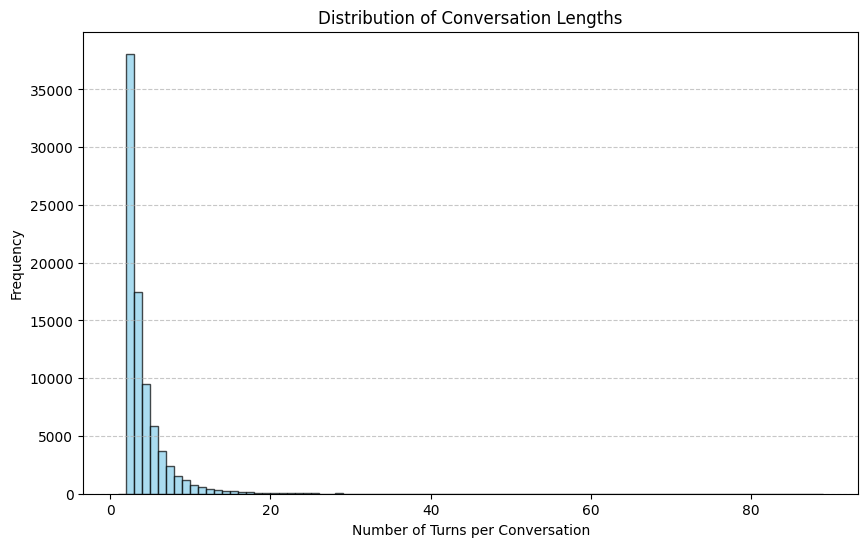

In [33]:
analyze_conversation_lengths(conversational_data, conversation_id_column='Conversation ID', turn_column='Turn ID')

**Summary Highlights:**

Based on above: 

* Total Conversations: `83,097` conversations.
* Minimum Turns: `2` turns, indicating some very short dialogues.
* Maximum Turns: `89` turns, though these are likely outliers.
* Average Turns: `3.67`, suggesting most conversations are quite brief.
* Median Turns: `3`, meaning half of the conversations are `3` turns or fewer.
* 25th Percentile: `2` turns—a quarter of conversations are extremely short.
* 75th Percentile: `4` turns—most conversations are between `2` to `4` turns.
* The histogram shows a very sharp decline after `2-4` turns, meaning most conversations are short.
* Very few conversations go beyond 10 turns, with a long tail extending to `89` turns.

